# Show responses of energy balance model

In [19]:
import os

from fair.energy_balance_model import EnergyBalanceModel
import matplotlib.pyplot as pl
import pandas as pd
import numpy as np

In [2]:
cmip6_output_df = pd.read_csv('../data/calibration/v1.4.1/4xCO2_cmip6.csv')
cmip6_output_df.head()

,activity_id,climate_model,member_id,mip_era,model,region,scenario,unit,variable,X1850,...,X1990,X1991,X1992,X1993,X1994,X1995,X1996,X1997,X1998,X1999
0,CMIP,MPI-ESM1-2-HR,r1i1p1f1,CMIP6,unspecified,World,abrupt-4xCO2,W m^-2,tas,1.219246,...,4.839437,4.762517,5.013192,4.967421,4.881265,4.836743,4.951499,4.915478,4.880026,4.929659
1,CMIP,MPI-ESM1-2-HR,r1i1p1f1,CMIP6,unspecified,World,abrupt-4xCO2,W m^-2,rlut,-5.520123,...,0.229722,0.091120,0.128996,0.409697,-0.071273,-0.052620,0.216034,0.393391,0.324886,0.287846
2,CMIP,MPI-ESM1-2-HR,r1i1p1f1,CMIP6,unspecified,World,abrupt-4xCO2,W m^-2,rsut,-1.154046,...,-1.637326,-1.874923,-1.648490,-1.156651,-1.444657,-1.830072,-1.930803,-1.513210,-1.846653,-1.705947
3,CMIP,MPI-ESM1-2-HR,r1i1p1f1,CMIP6,unspecified,World,abrupt-4xCO2,W m^-2,rsdt,-0.003877,...,-0.003868,-0.003868,0.012090,-0.003868,-0.003868,-0.003868,0.012090,-0.003868,-0.003868,-0.003868
4,CMIP,MPI-ESM1-2-HR,r1i1p1f1,CMIP6,unspecified,World,abrupt-4xCO2,W m^-2,rndt,6.670292,...,1.403735,1.779935,1.531583,0.743086,1.512062,1.878824,1.726859,1.115952,1.517899,1.414233


In [3]:
# where models submit more than one simulation, we choose the one that looks the most stable
multi_runs = {
    "GISS-E2-1-G": "r1i1p1f1",
    "GISS-E2-1-H": "r1i1p3f1",
    "MRI-ESM2-0": "r1i1p1f1",
    "EC-Earth3": "r3i1p1f1",
    "FIO-ESM-2-0": "r1i1p1f1",
    "CanESM5": "r1i1p2f1",
    "FGOALS-f3-L": "r1i1p1f1",
    "CNRM-ESM2-1": "r1i1p1f2",
}

In [4]:
models = cmip6_output_df.climate_model.unique()

In [8]:
tas_cmip6 = {}
for model in models:
    if model in multi_runs:
        tas_cmip6[model] = cmip6_output_df.loc[
            (cmip6_output_df['climate_model']==model) & 
            (cmip6_output_df['member_id']==multi_runs[model]) & 
            (cmip6_output_df['variable']=='tas'), 
            'X1850':'X1999'
        ].values.squeeze()
    else:
        tas_cmip6[model] = cmip6_output_df.loc[
            (cmip6_output_df['climate_model']==model) & 
            (cmip6_output_df['variable']=='tas'), 
            'X1850':'X1999'
        ].values.squeeze()

In [20]:
ebm_fits_df = pd.read_csv('../data/calibration/v1.4.1/4xCO2_cummins_ebm3_cmip6.csv')
ebm_fits_df.head()

,model,run,conv,nit,gamma,C1,C2,C3,kappa1,kappa2,kappa3,epsilon,sigma_eta,sigma_xi,F_4xCO2
0,MPI-ESM1-2-HR,r1i1p1f1,True,5675,3.489175,5.119944,23.638241,72.761041,1.171723,1.592417,1.114562,1.562697,0.569929,0.437150,7.823786
1,CAMS-CSM1-0,r1i1p1f1,True,5278,27.432983,2.626057,9.130623,52.887882,1.877863,5.190848,0.646955,1.272054,2.659112,0.441941,8.862573
2,BCC-ESM1,r1i1p1f1,True,3871,1.880547,5.353527,15.825581,77.401496,0.884922,1.479110,0.914739,1.293948,0.389056,0.314778,6.253645
3,MRI-ESM2-0,r10i1p1f1,True,3769,2.478552,3.517631,9.377711,99.061180,1.103585,3.718621,1.093898,1.345655,0.708233,0.601146,7.572056
4,MRI-ESM2-0,r1i1p1f1,True,3042,2.993394,4.243314,10.524134,94.082565,1.108786,2.851240,1.250350,1.333253,0.976875,0.515179,7.562982


In [45]:
# run 150 year 4xCO2 with the calibrations
ebm3 = {}
for isp, model in enumerate(models):
    print(model)
    if model in multi_runs:
        params = ebm_fits_df.loc[
            (ebm_fits_df['model']==model) &
            (ebm_fits_df['run']==multi_runs[model]),
            'gamma':
        ]
    else:
        params = ebm_fits_df.loc[ebm_fits_df['model']==model, 'gamma':]
    ebm3[model] = EnergyBalanceModel(
        ocean_heat_capacity=[params["C1"].values[0], params["C2"].values[0], params["C3"].values[0]],
        ocean_heat_transfer=[params["kappa1"].values[0], params["kappa2"].values[0], params["kappa3"].values[0]],
        deep_ocean_efficacy=params["epsilon"].values[0],
        gamma_autocorrelation=params["gamma"].values[0],
        sigma_xi=params["sigma_xi"].values[0],
        sigma_eta=params["sigma_eta"].values[0],
        forcing_4co2=params["F_4xCO2"].values[0],
        stochastic_run=True,
        seed=10000 * isp + 700  # reproducibility, but a different stochastic seed per model
    )
    ebm3[model].add_forcing(np.ones(151) * params["F_4xCO2"].values[0], timestep=1)
    ebm3[model].run()

MPI-ESM1-2-HR
CAMS-CSM1-0
BCC-ESM1
MRI-ESM2-0
E3SM-1-0
INM-CM4-8
IPSL-CM6A-LR
CanESM5
IITM-ESM
MIROC6
CESM2-FV2
CAS-ESM2-0
INM-CM5-0
CESM2-WACCM-FV2
MPI-ESM-1-2-HAM
CESM2-WACCM
MPI-ESM1-2-LR
FGOALS-g3
SAM0-UNICON
CNRM-CM6-1-HR
FIO-ESM-2-0
GFDL-ESM4
CMCC-CM2-SR5
EC-Earth3
CNRM-CM6-1
HadGEM3-GC31-MM
FGOALS-f3-L
KACE-1-0-G
AWI-CM-1-1-MR
GISS-E2-2-G
GFDL-CM4
BCC-CSM2-MR
CNRM-ESM2-1
UKESM1-0-LL
NESM3
HadGEM3-GC31-LL
NorESM2-MM
MIROC-ES2L
KIOST-ESM
TaiESM1
NorESM2-LM
GISS-E2-1-G
EC-Earth3-Veg
CESM2
NorCPM1
ACCESS-ESM1-5
ACCESS-CM2
CIESM
GISS-E2-1-H


In [43]:
ebm3["GISS-E2-1-H"].temperature

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.03381597e+00, 1.78991610e-01, 6.42226677e-04],
       [1.69531736e+00, 5.74478604e-01, 4.34542601e-03],
       [1.91586304e+00, 9.52117598e-01, 1.20872595e-02],
       [2.20124298e+00, 1.26373264e+00, 2.31124913e-02],
       [2.44813749e+00, 1.53671539e+00, 3.69000316e-02],
       [2.63985848e+00, 1.75381708e+00, 5.30017888e-02],
       [2.96616752e+00, 1.99628366e+00, 7.12389414e-02],
       [2.78424007e+00, 2.14858750e+00, 9.14132091e-02],
       [3.33918416e+00, 2.32518670e+00, 1.12790159e-01],
       [3.09927333e+00, 2.47044495e+00, 1.35801523e-01],
       [3.51318955e+00, 2.62662432e+00, 1.59965844e-01],
       [3.55390161e+00, 2.77508620e+00, 1.85490921e-01],
       [3.64563784e+00, 2.88238739e+00, 2.11990468e-01],
       [3.82827816e+00, 2.97686614e+00, 2.39203174e-01],
       [3.70568925e+00, 3.05155288e+00, 2.67048642e-01],
       [3.82654971e+00, 3.10972322e+00, 2.95136567e-01],
       [3.86799341e+00, 3.18805

In [74]:
# font.size           : 12
# font.family         : Arial
# ytick.direction     : in
# ytick.minor.visible : True
# ytick.major.right   : True
# ytick.right         : True
# xtick.direction     : in
# xtick.minor.visible : True
# xtick.major.top     : True
# xtick.top           : True
# axes.spines.top     : True
# axes.spines.bottom  : True
# figure.dpi          : 150
pl.rcParams['font.size'] = 7
pl.rcParams['ytick.major.right'] = True
pl.rcParams['ytick.right'] = True
pl.rcParams['xtick.major.top'] = True
pl.rcParams['xtick.top'] = True
pl.rcParams['xtick.direction'] = 'in'
pl.rcParams['ytick.direction'] = 'in'

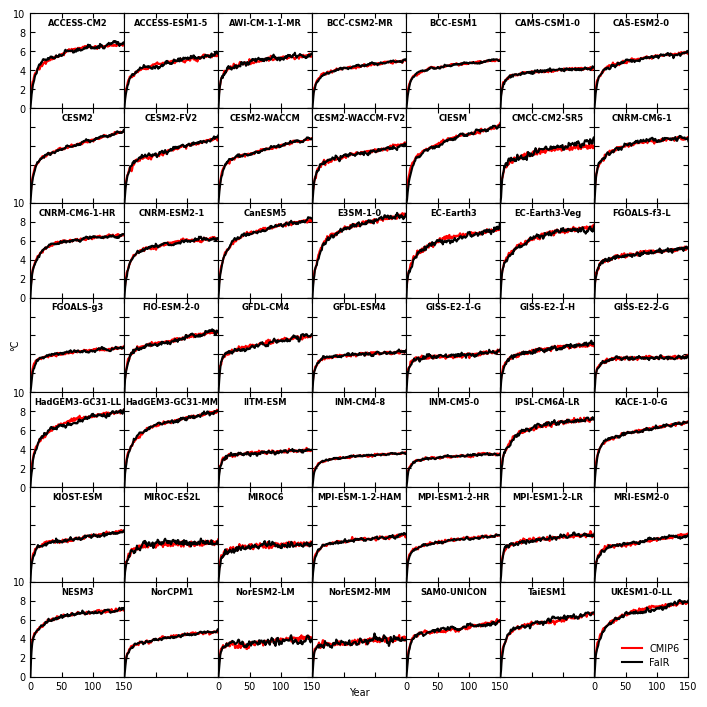

In [84]:
fig, ax = pl.subplots(7, 7, figsize=(18/2.54, 18/2.54))
for isp, model in enumerate(sorted(models)):
    row = isp//7
    col = isp%7
    label1 = 'CMIP6' if model=='UKESM1-0-LL' else ''
    label2 = 'FaIR' if model=='UKESM1-0-LL' else ''
    ax[row, col].plot(np.arange(0.5, 150), tas_cmip6[model], color='r', label=label1)
    ax[row, col].plot(np.arange(151), ebm3[model].temperature[:, 0], color='k', label=label2)
    ax[row, col].set_xlim(0,150)
    ax[row, col].set_ylim(0, 10)
    ax[row, col].text(75, 8.5, model, fontsize=6, ha='center', va='bottom', fontweight='bold')
    ax[row, col].set_xticks([0, 50, 100, 150])
    ax[row, col].set_yticks([0, 2, 4, 6, 8, 10])
    if row<6 or col%2==1:
        ax[row, col].set_xticklabels([])
    if col>0 or row%2==1:
        ax[row, col].set_yticklabels([])
ax[6,3].set_xlabel('Year')
ax[3,0].set_ylabel('°C')
ax[6,6].legend(loc='lower right', frameon=False)
fig.tight_layout()
pl.subplots_adjust(wspace=0, hspace=0)

os.makedirs('../plots/', exist_ok=True)
pl.savefig('../plots/ebm3_150.png')
pl.savefig('../plots/ebm3_150.pdf')